In [1]:
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import lax, make_jaxpr, random, device_put

import matplotlib.pyplot as plt

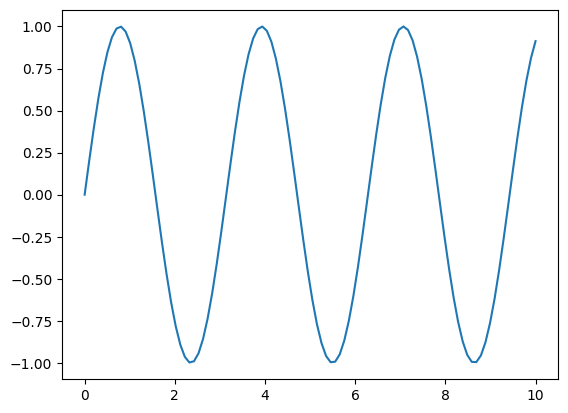

In [2]:
#numpy
x_np = np.linspace(0,10,100)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np,y_np)

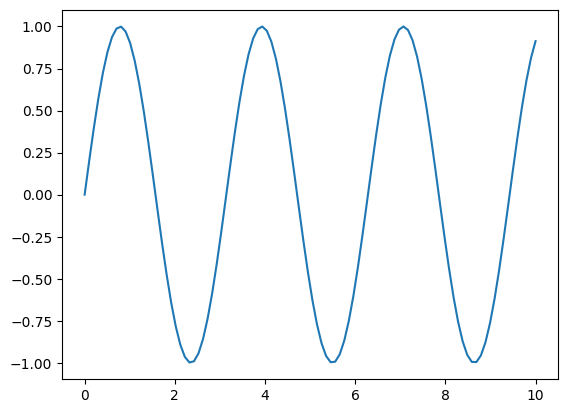

In [3]:
#jax
x_np = jnp.linspace(0,10,100)
y_np = 2 * jnp.sin(x_np) * jnp.cos(x_np)
plt.plot(x_np,y_np)

In [4]:
size, index, value = 10,0,23

#numpy arrays are mutable
x=np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [7]:
#jax arrays are immutable
x=jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [9]:
x = x.at[index].set(value)
print(x)

[23  1  2  3  4  5  6  7  8  9]


In [11]:
#jax dont do random the same way
seed = 0
key = random.PRNGKey(seed)
x = random.normal(key,(10,))
print(type(x),x) #Device array

<class 'jaxlib._jax.ArrayImpl'> [ 1.6226422   2.0252647  -0.43359444 -0.07861735  0.1760909  -0.97208923
 -0.49529874  0.4943786   0.6643493  -0.9501635 ]


In [14]:
size = 1000

x_jnp = random.normal(key,(size,size),dtype=jnp.float32)
x_np = np.random.normal(size = (size,size)).astype(np.float32)
%timeit jnp.dot(x_jnp,x_jnp.T).block_until_ready() #would be faster if we had GPU
%timeit np.dot(x_np,x_np.T)
%timeit jnp.dot(x_np,x_np.T).block_until_ready() #variance is less since we have warmed up

4.2 ms ± 238 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.4 ms ± 76.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.15 ms ± 150 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device,x_np_device.T).block_until_ready()

3.77 ms ± 187 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


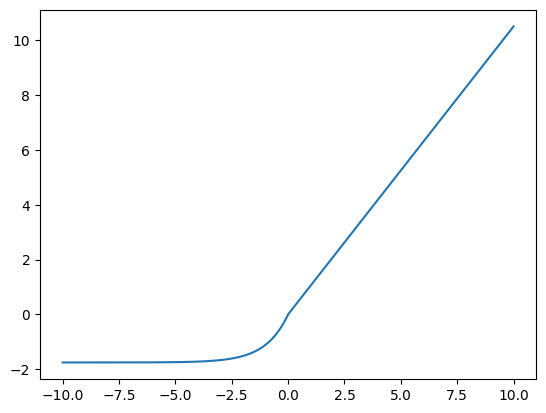

In [17]:
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()
selu_jit = jit(selu)
visualize_fn(selu)

In [18]:
data = random.normal(key, (1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

non-jit version:
1.31 ms ± 15.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jit version:
362 μs ± 17.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))
x = jnp.arange(3.)
grad_loss = grad(sum_logistic)
print(grad_loss(x))

[0.25       0.19661197 0.10499357]


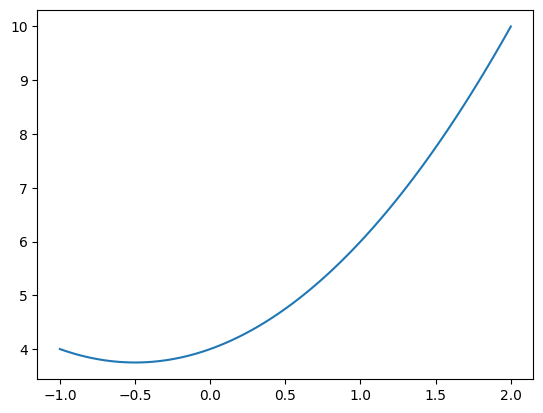

In [21]:
x = 1.0
f = lambda x:x**2 + x + 4
visualize_fn(f,l=-1,r=2,n=100)

In [22]:
dfdx = grad(f)
d2fdx = grad(dfdx)
d3fdx = grad(d2fdx)
print(f(x),dfdx(x),d2fdx(x),d3fdx(x))

6.0 3.0 2.0 0.0


In [25]:
from jax import jacfwd, jacrev #forward , backprop

f = lambda x,y : x**2 + y**2

def hessian(f):
    return jit(jacfwd(jacrev(f,argnums=(0,1)),argnums = (0,1)))

In [26]:
print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


In [27]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(x):
    return jnp.dot(W, x)